In [1]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.fair import BinaryFair
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from tqdm.auto import trange

%load_ext autoreload
%autoreload 2

In [2]:
# Parameters
data_file = torch.load("data/Crime/data.pt")
params = {'batch_size': 128,
          'shuffle': True}
# Generators
training_set = TensorDataset(data_file['data'], data_file['context'], data_file['labels'])
training_generator = torch.utils.data.DataLoader(training_set, **params)


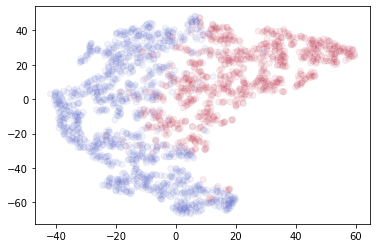

In [3]:
X_embedded = TSNE(n_components=2).fit_transform(data_file['data'])
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.07, cmap='coolwarm')

In [4]:
gamma = 1.
Fair = BinaryFair(data_dim=data_file['data'].shape[-1], 
                  context_dim=data_file['context'].shape[-1], 
                  flow_n_layers = 3,
                  flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                  classifier_hidden_dim = 32,
                  classifier_n_layers = 4,
                  classifier_activation = 'ReLU',
                  gamma=gamma
                 )
optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-2, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [10]:
n_epochs = 10
Fair.train()
for n_epoch in trange(n_epochs):
    for n_step, (data, context, labels) in enumerate(training_generator):
        optimizer.zero_grad()

        L_KL, L_clf, loss = Fair.loss(data, context, labels, return_all_losses=True)

        total_losses.append(loss.item())
        KL_losses.append(L_KL.item())
        clf_losses.append(L_clf.item())

        loss.backward()
        optimizer.step()
Fair.eval();

  0%|          | 0/10 [00:00<?, ?it/s]

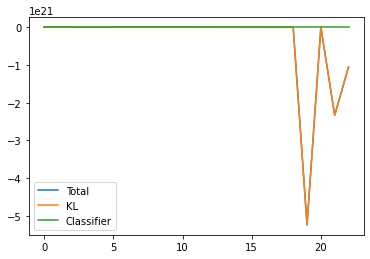

In [11]:
plt.plot(total_losses, label="Total")
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(KL_losses, label="KL")
plt.plot(clf_losses, label="Classifier")
plt.legend()
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.show()

In [17]:
Fair.sample(2)

tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]], grad_fn=<AddBackward0>)

In [12]:
with torch.no_grad():
    cont_pred = Fair(data_file['data'], data_file['context']).sigmoid()
    bin_pred = (cont_pred > 0.5).int()
    acc = accuracy_score(bin_pred, data_file['labels'])
acc

0.5

Accuracies:
    gamma = 0. : 0.84  # paper achieves 85.2 (not too far off)
    gamma = 1. : 0.5

In [13]:
with torch.no_grad():
    embedding = Fair.embed(data_file['data'], data_file['context'])[0]
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.02, cmap='coolwarm')

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [14]:
with torch.no_grad():
    embedding = Fair.embed(data_file['data'], 0*data_file['context'])[0]
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.02, cmap='coolwarm')

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
with torch.no_grad():
    embedding = Fair.embed(data_file['data'], 1+0*data_file['context'])[0]
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.02, cmap='coolwarm')

In [ ]:
n_samples = 1000
with torch.no_grad():
    samples_0 = Fair.sample(1, context=torch.zeros(n_samples, 1)).squeeze(1)
    samples_1 = Fair.sample(1, context=torch.ones(n_samples, 1)).squeeze(1)
EmpiricalStatisticalDistance(samples_0, samples_1, 
                             hidden_dim=32, n_layers=2, n_epochs=100)